# Epidemic

## Introduction 

Understanding how epidemics begin and spread is very important. This project explores the dynamics of an epidemic. Using simulation based code, each cell in the population of a $200$ $x$ $200$ grid represents a healthy, sick, recovered or vaccinated cell. Through observing the interactions of sick cells onto their live neighbors, we can see how to quickly the cells are infected as well as their recovery times. 

We can observe how different infection conditions like the rates of infection, impact the outcome and speed of the spread. If a cell is healthy one day, then the probability that it will get sick the next dat is $1 - (1 - p_{I})^{k}$, where $k$ is the number of neighbors of the cell which are sick. If a cell is sick one day then the probability that it will be healed the next day is $p_{R}$. If a cell is healed, then it won't get sick ever again. 

The main goal of this report is to build our understanding of the key parameters that influence how an contagious diseases can spread so fast. 

## Modeling the Spread

In order to create our simulation for the spread, we need to create a `starting_state` function to create our grid of healthy individuals that have a $4$ x $4$ grid of infected cells in the center. 

In order to show the spread, we need to know how many sick neighbors each cell has. To do this we create the `get_live_neighbors_counts` function. 

Once we finish that, we can move on to our `update_spread` function that updates the state of our grid at each time. Using the counts we got from our `get_live_neighbors_counts` function, it calculates the probability `p_I` (probability of healthy cells becoming infected) and `p_R` (probability of sick cells recovering). These function work to model the spread of the disease and assess how different probabilies change the outlook. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

# Import the colors module to create custom colors for our simulation 
from matplotlib import colors

# Import FuncAnimation to animate our simulations
from matplotlib.animation import FuncAnimation

In [3]:
def starting_state(n):
    
    # Create a n x n grid of healthy cells
    cells = np.zeros((n, n), dtype=int)
    
    # Creates a 4 x 4 grid of infeced cells at its center
    cells[n//2-2:n//2+2, n//2-2:n//2+2] = 1
    
    return cells

In [76]:
n = 200 # We want the size of our grid is 200

cells = starting_state(n)

Neighboring cells include all the cells adjacent to our sick cells. We define a function `get_live_neighbor_count` to count how many live neighbors each sick cell has and to add that into `k`: the number of sick neighbors around the cell. 

In [5]:
def get_live_neighbor_counts(cells):
    num_rows, num_cols = cells.shape
    
    # Create a padded array to hold 16 shifted versions of our grid
    padded_cells_shifts = np.zeros((num_rows+3, num_cols+3, 16),dtype=int)

    k = 0 
    for i in range(4):  
        for j in range(4):
            
            #For each shift, copy the grid over into our padded cells shift
            padded_cells_shifts[i:num_rows + i, j:num_cols + j, k] = cells
            k += 1
    
    # Gives us our rows and column array of cell states from the shifted positions
    cells_shifts = padded_cells_shifts[1:num_rows+1, 1:num_cols+1, :]
    
    # Then count how many of the neighbors are in the state 1 (sick state)
    # Subtract to avoid overlap 
    live_neighbor_counts = (cells_shifts == 1).sum(axis=2) - (cells == 1)
    
    # Return the number of live (sick) neighbors for each cell
    return live_neighbor_counts

The `update_spread` function takes a $200$ x $200$ grid of cells with given states $0$ = healthy, $1$ = sick, and $2$ = recovered and returns the grid showing the states of the cells on the next days. 

First, it calculates how many of each cell's neighbors are sick then it creates a randomized grid of numbers between $0$ and $1$ for each cell. The `infection_prob` array shows the probability of infection based on the numbr of infected neighbors. The formula used is $1 - (1 - p_{I})^{k}$. The `infect_mask` is a boolean array that identifies all healthy cells where the random number assigned to it is less than the infection probability, in turn makign those cells sick. 

In a similar fashion, the `recover_grid` is another array used to determine whether a sick individual cna recover based on its recovery probability $p_{R}$. All cells where the mask is `True` are set to a new state and the function returns the newly updated grid. 

In [77]:
def update_spread(cells, p_I, p_R):
    num_rows, num_cols = cells.shape
    
    # Count sick neighbors surrounding
    live_neighbor_counts = get_live_neighbor_counts(cells)
    random_grid = np.random.random(cells.shape) # Generate random values
    new_cells = cells.copy()
    
    # Calculate the probability that a healthy cell becomes sick
    infection_prob = 1 - (1 - p_I) ** live_neighbor_counts
    
    # Create a mask for healthy cells that become sick based on infection prob
    infect_mask = (cells == 0) & (random_grid < infection_prob)
    new_cells[infect_mask] = 1 #Update cells 
    
    # Another random grid to determine recovery for sick cells
    recover_grid = np.random.random(cells.shape)
   
    # Create a mask for sick cells that recover based on recovery prob
    recover_mask = (cells == 1) & (recover_grid < p_R)
    new_cells[recover_mask] = 2 # Update cells
    
    # Returns the updated grid
    return new_cells

To run the simulation for different values of $p_{I}$ and $p_{R}$, I looked to created a dynamic `run_simulation` function to output a visual of our epidemic spread based on these given parameters. Using `matplotlib.pyplot`, I was able to set up a clear visualization fo the colors. 
- `Green` = healthy 
- `Black` = sick
- `Orange` = recovered
`ListedColormap` is a Colormap object generated froma list of colors. Colormap is a feature of Python that is a "baseclass for all scalr to RBGA mappings". 

The animation of the simulation is defined in the nested `animate` function called by `FuncAnimation`. Over each time step, our `update_spread` function computes the next stage of the epidemic and the spread based on the two parameters, $p_{I}$ and $p_{R}$. This provides a nice visual to see how different factors can affect the dynamics of an epidemic 

In [78]:
def run_simulation(p_I, p_R, n=200):
    
    cells = starting_state(n)
    
    # Create a new figure for the animation
    fig = plt.figure()
    
    # DEfine our own custom color map for visualizing the states
    cmap = colors.ListedColormap(['green', 'black', 'orange'])
    im = plt.imshow(cells, cmap=cmap, vmin=0, vmax=2)

    # Define the animation function that updates the grid
    def animate(i):
        # Calculate the next state of the grid based on the spread change in prob
        new_cells = update_spread(cells, p_I=p_I, p_R=p_R)
        cells[:,:] = new_cells # Update the original grid
        
        # Update the image data to reflect new state
        im.set_data(cells)
        return [im]

    # Create the animation by calling the `animate` function over 
    anim = FuncAnimation(fig,animate,cache_frame_data=False)
    return anim

### Experimentation

Now we look to explore the effect the model parameters $p_{I}$ and $p_{R}$ on the spread of the disease. Using the simulation visual along with soem static plots, we can really see where differences lie. Let's test different values of $p_{I}$ and $p_{R}$ on our `run_simulation` function.  

<IPython.core.display.Javascript object>


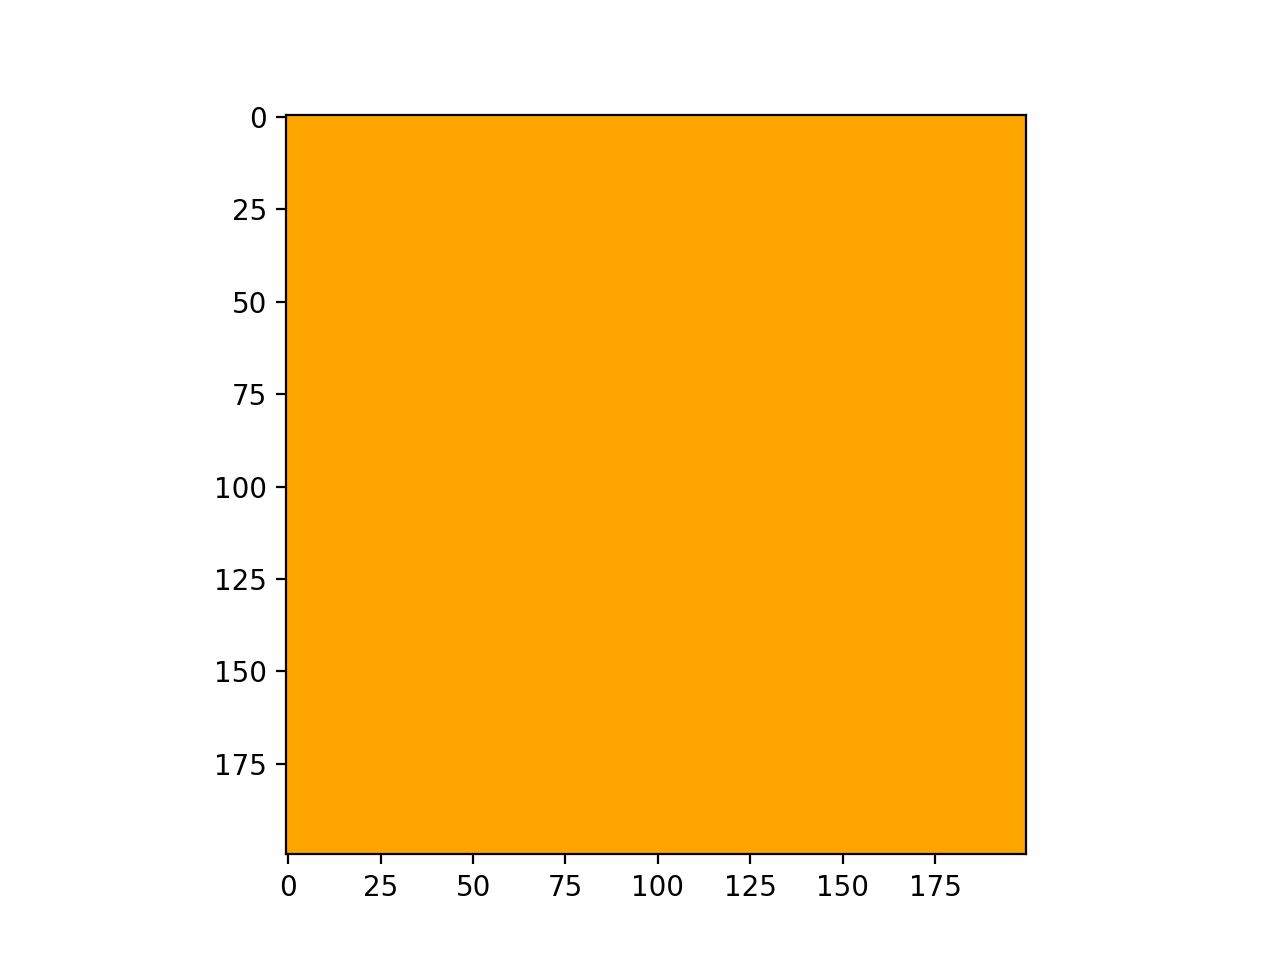

In [8]:
run_simulation(p_I=0.3, p_R=0.1)

<IPython.core.display.Javascript object>


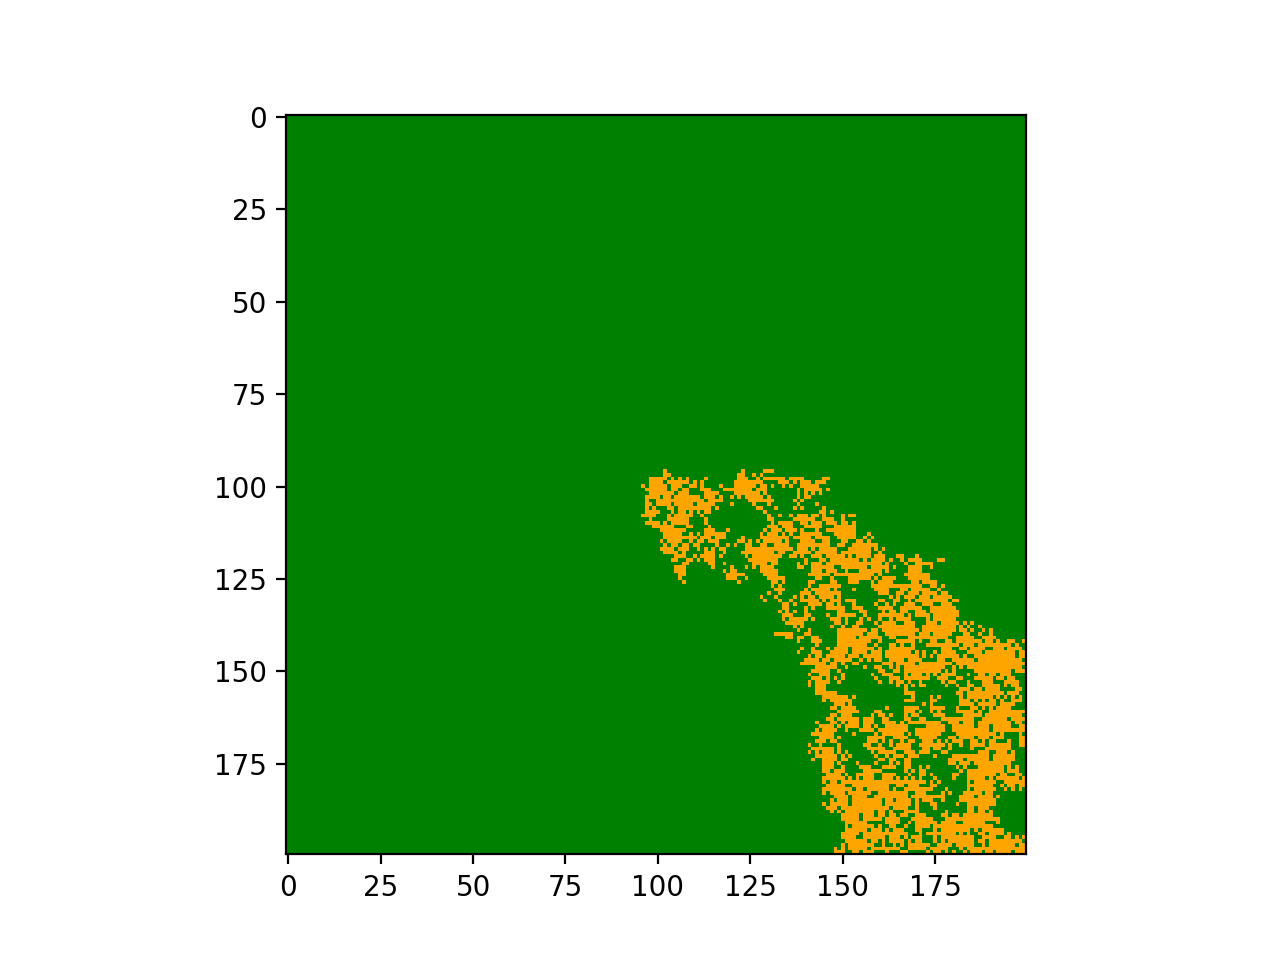

In [9]:
run_simulation(p_I=0.1, p_R=0.9)

### Observations for Simualtion

The values of $p_{I}$ and $p_{R}$ behave differently depending on their value. Based on these two simulation runs, high $p_{I}$ and low $p_{R}$ means that the inflection spreads rapidly, a large portion of the grid becomes sick and recovery takes a while but all of the cells recover. Another thing of note is that there are no healthy cells left.

Conversely, when $p_{I}$  is low and $p_{R}$ is high, the spread of infection is slow, there is a low sick count and the disease dies down pretty fast. As you can see it doesn't go very far in the grid. There were a lot of healthy cells yet as the outbreak was short.

### Static Plots

Static plots are neccessary in order for us to interprey the behavior of the cells of the epidemic over time or over the course of a ccertain number of runs. This plot gives us a clear outlook on the number of sick individuals and how that number changes over time. We can compare different parameters settings easily through this different type of visualization. 

To do this, we generate the `plot_live_cells_counts` function. 

In [79]:
def plot_live_cells_counts(n,T,p_I, p_R):
    plt.figure()
    
    cells = starting_state(n)
    # Store the number of live cells (cells == 1)
    sick_counts = []
    
    # Create an axis of time 
    t_list = np.arange(T)
    
    # Run the simualtion for T time steps
    for t in range(T):
        sick_counts.append(np.sum(cells == 1))  # Count sick cells at time t
        cells = update_spread(cells, p_I, p_R)  # Update the grid
    
    # Plot the number of sick cells over time
    plt.plot(t_list, sick_counts, label='Sick', color='red')
    plt.xlabel("Time")
    plt.ylabel("Number of Live Cells")
    plt.title("Epidemic Spread")
    plt.legend()
    plt.show()


<IPython.core.display.Javascript object>


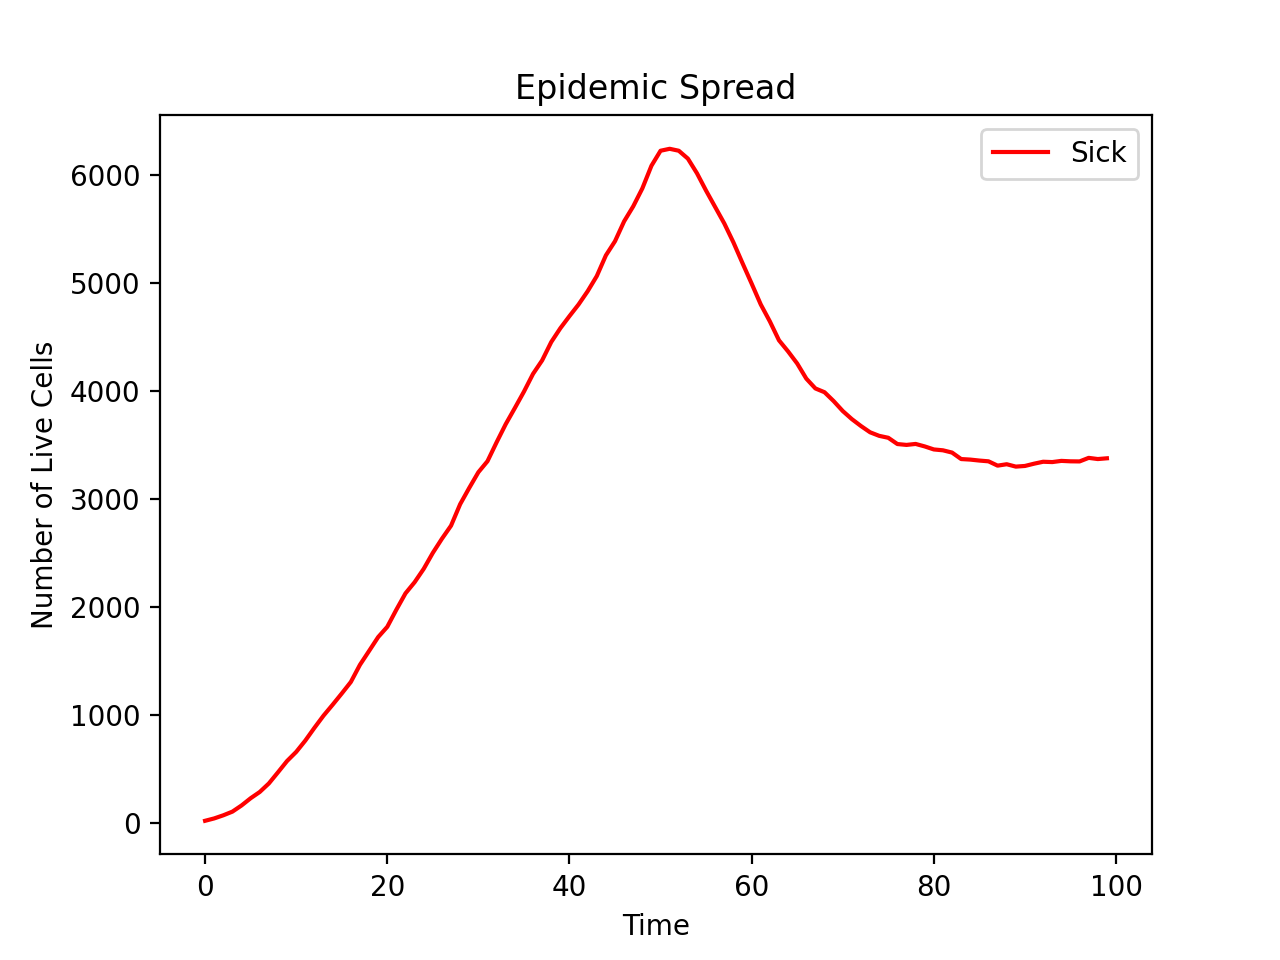

In [11]:
plot_live_cells_counts(n=200,T=100,p_I=0.3, p_R=0.1)

<IPython.core.display.Javascript object>


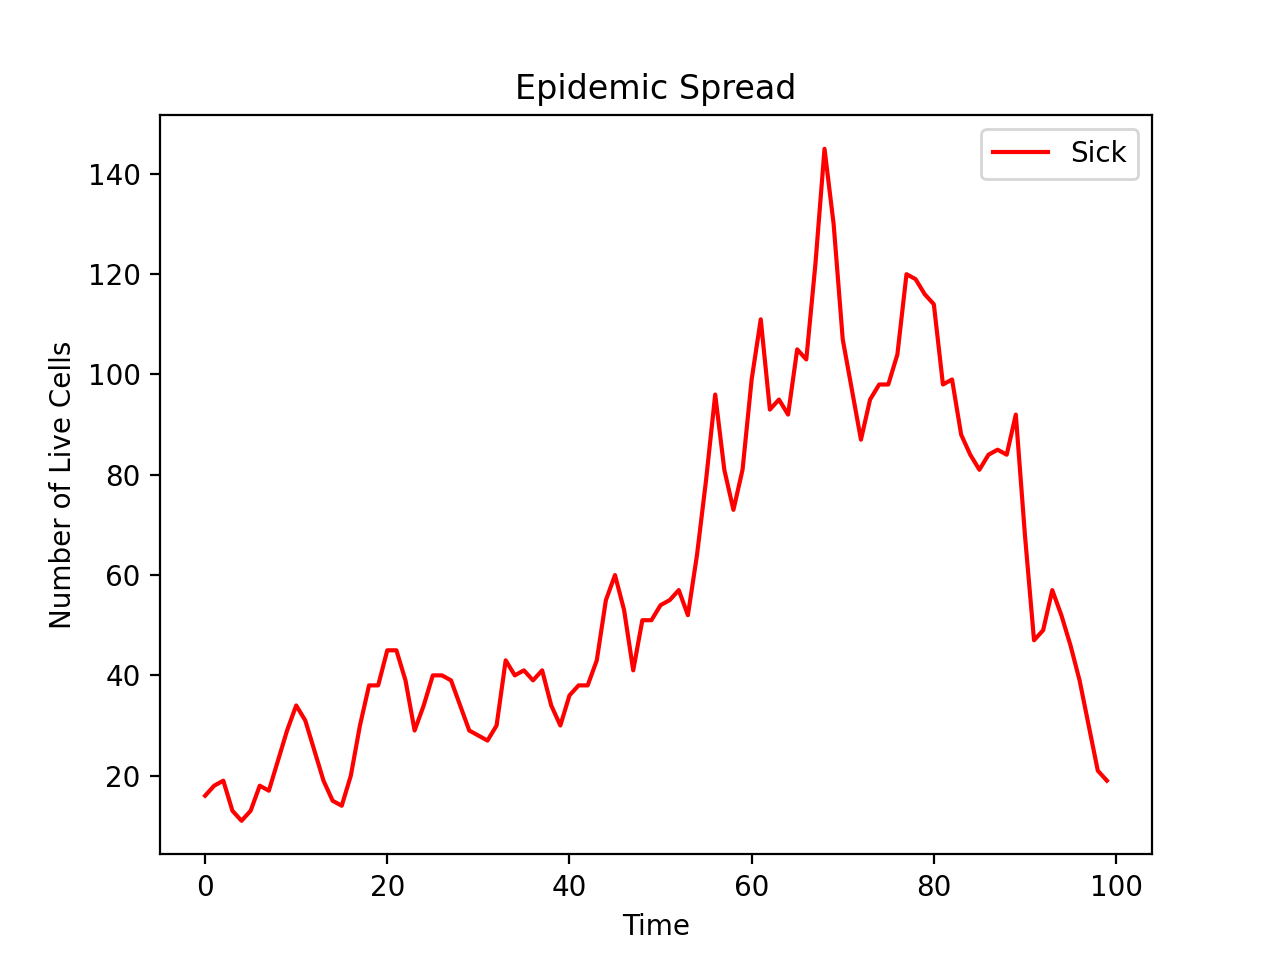

In [12]:
plot_live_cells_counts(n=200,T=100,p_I=0.1, p_R=0.9)

### Observations of Static Plots

The first plot of `T=100` runs, $p_{I}$ = $0.3$ and $p_{R}$ = $0.1$. The number of live cells increases rapidly but once it reaches over $6,000$ it starts to decrease at a slow rate. This can represents a hgihly contagious epidemic that spreads rapidly and the recovery rate is low. The infection spreads quickly and affects a lot of the population. 

The second plot of `T=100` runs,  $p_{I}$ = $0.1$ and $p_{R}$ = $0.9$.The disease is clearly less contagious as there are so few live neighbor cells and the recovery is pretty quick. Although the graph depicts variablitly, it is only because the y-axis differs from that of the first one (the limits are much bigger). As a result, the number of sick individuals never gets too high and just continues to fluctuate over time. 

## What if a vaccine was introduced? 

Imagine a world where a vaccine was invented for the disease that we are measuring. A vaccinated cell will have the value of $-1$ and that cell can never get sick. We can define a function `starting_state_vaccinated` that makes a randomly selected percentage of cells in the population on our grid vaccinated. 

In [80]:
def starting_state_vaccinated(n, rate):
    cells = np.zeros((n, n), dtype=int)
    # Infect a 4 x 4 grid of cells in the center 
    cells[n//2-2:n//2+2, n//2-2:n//2+2] = 1
    
    # Create a boolean mask where each cell has a rate of being True
    mask = np.random.rand(n, n) < rate
    
    # Apply the mask to set vaccinated cells to -1
    cells[mask] = -1

    return cells

Similarly to before, we want to generate a simulation but this time we want to include our vaccinated cells. Now we add `blue` into our custom list in order to visualize our random percentage of vaccinated cells. The simualtion function is the same but we add in our `starting_state_vaccinated` as the official starting rate.

In [83]:
def run_simulation_vaccinated(p_I, p_R,rate,n=200):
    
    # New starting state to account for our vaccinated cells 
    cells = starting_state_vaccinated(n, rate)

    # Create a new figure for the animation
    fig = plt.figure()
    
    # Define our own custom color map for visualizing the states
    cmap = colors.ListedColormap(['blue','green', 'black', 'orange'])
    im = plt.imshow(cells, cmap=cmap, vmin=-1, vmax=2)

    # Define the animation function that updates the grid
    def animate(i):
        # Calculate the next state of the grid based on the spread change in prob
        new_cells = update_spread(cells, p_I=p_I, p_R=p_R)
        cells[:,:] = new_cells # Update the original grid
        
        # Update the image data to reflect new state
        im.set_data(cells)
        return [im]

    # Create the animation by calling the `animate` function over 
    anim = FuncAnimation(fig,animate,cache_frame_data=False)
    return anim

<IPython.core.display.Javascript object>


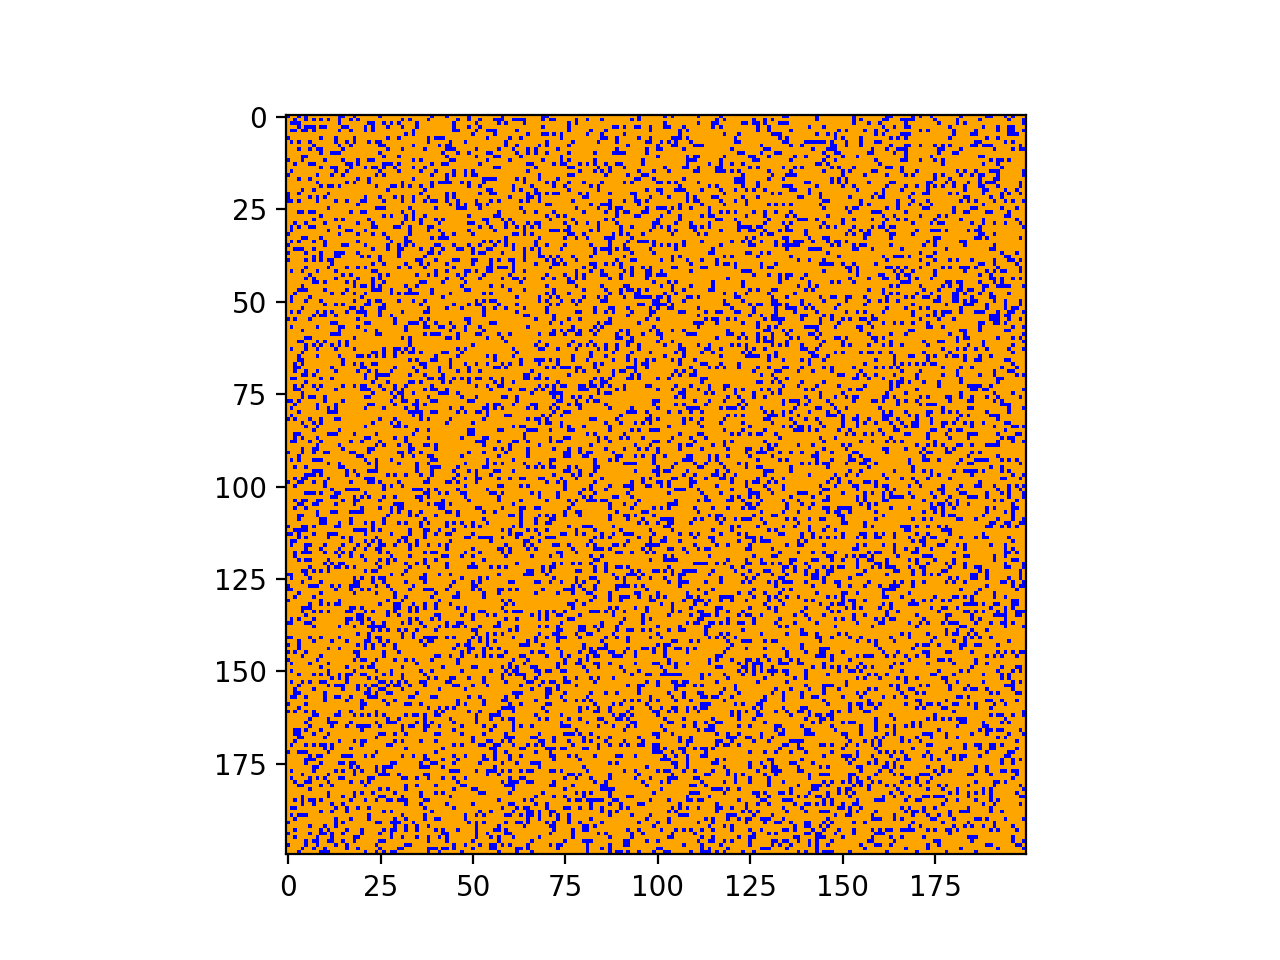

In [84]:
run_simulation_vaccinated(p_I=0.3, p_R=0.1, rate=.2)

<IPython.core.display.Javascript object>


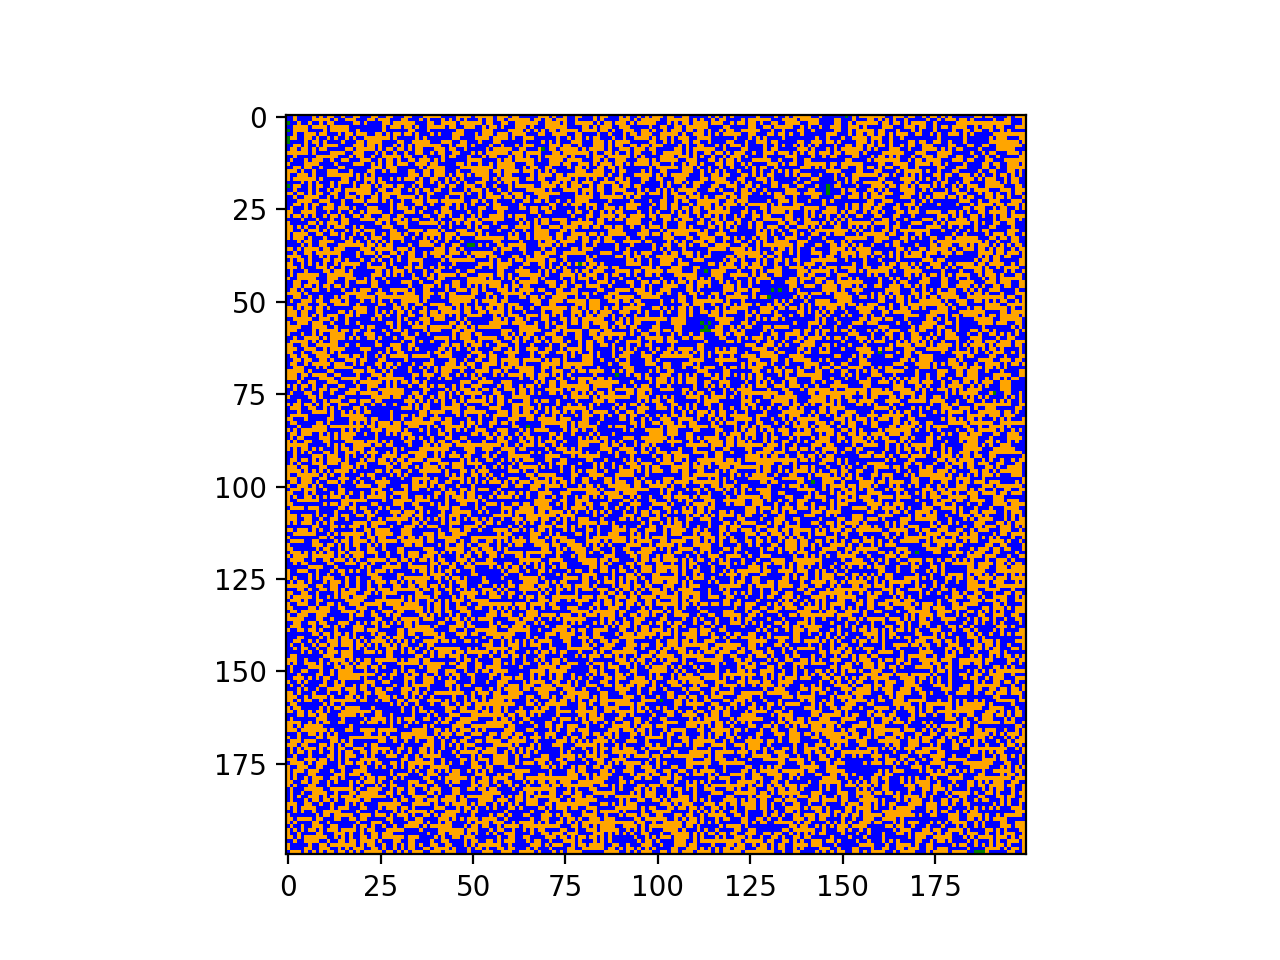

In [85]:
run_simulation_vaccinated(p_I=0.3, p_R=0.1, rate=.5)

### Observations from Vaccinated Simulations

If the vaccination rate is only $20$%, the disease still spreads fairly widely through the population. It is not enough to prevent a major ourbreak but there are some cells unaffected. For a $50$% vaccination rate, the epidemic spread is reduced by a lot. The number of infections appears to be lower and there is more resistance to this disease. 

### Vaccinated Static Plots 

We want to observe and analyze how varying rates of vaccination affect the spread of the epidemic. The function `get_vaccinated_counts` tracks the number of sick individuals over `T` steps. We then can call this function as many time as we'd like to examine how the spread of the illness changes as rates increase. 

In [86]:
def get_vaccinated_counts(n, T, p_I, p_R, rate):
    cells = starting_state_vaccinated(n, rate)
    # Store the number of infected cells
    vax_counts = []
    for t in range(T):
        vax_counts.append(np.sum(cells == 1)) # Count sick cells and store
        cells = update_spread(cells, p_I, p_R) # Update the state of the grid 
    return vax_counts

<IPython.core.display.Javascript object>


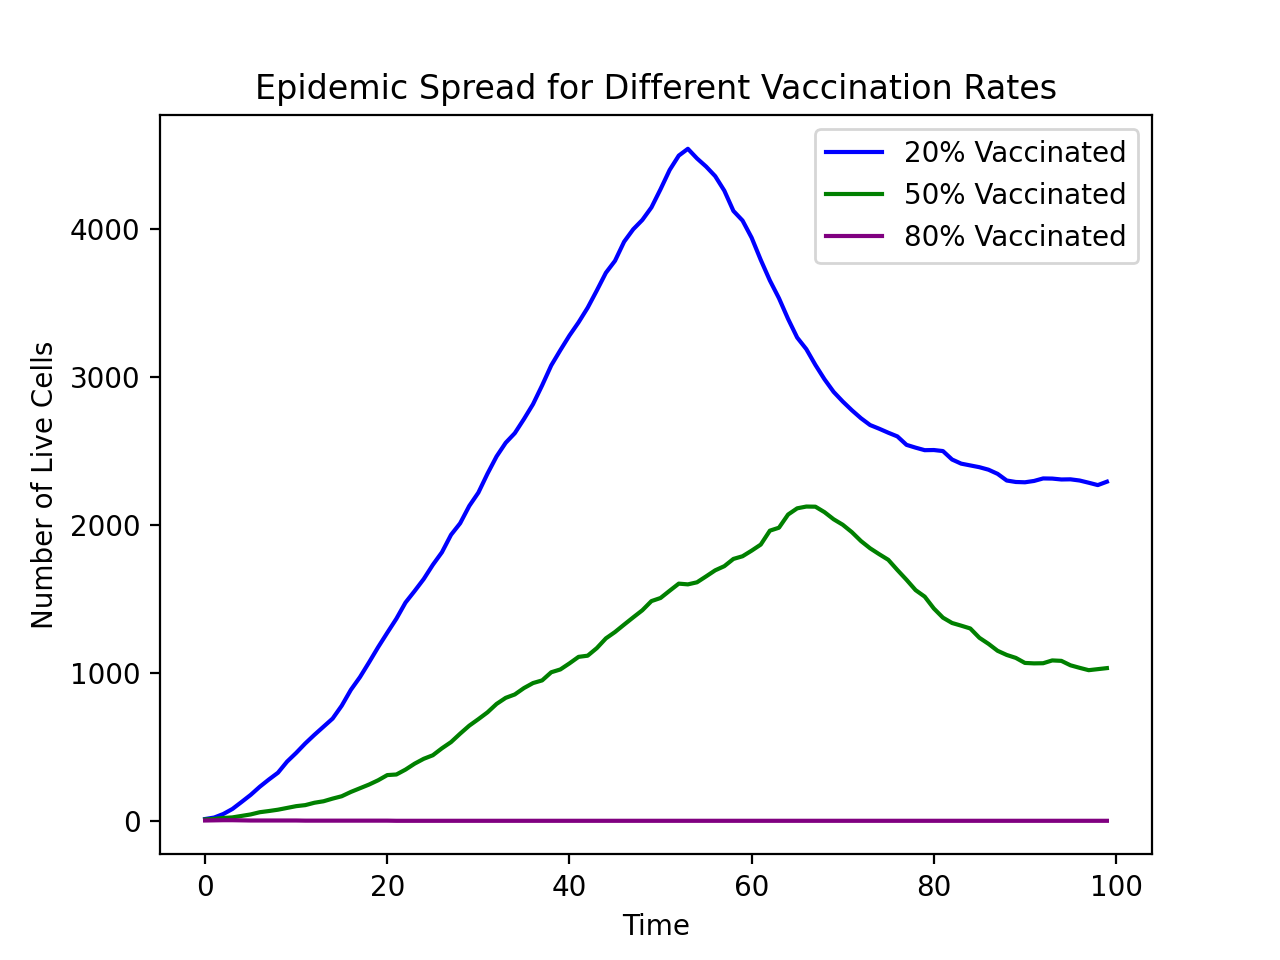

In [87]:
# How many time steps we want 
T = 100
t_list = np.arange(T) # Creates an array representing each time step

# Run the simulation for different percents of the pop vaccinated
vax_20 = get_vaccinated_counts(n=200, T=T, p_I=0.3, p_R=0.1, rate=0.2)
vax_50 = get_vaccinated_counts(n=200, T=T, p_I=0.3, p_R=0.1, rate=0.5)
vax_80 = get_vaccinated_counts(n=200, T=T, p_I=0.3, p_R=0.1, rate=0.8)

# Plot all on the same figure
fig = plt.figure()
plt.plot(t_list, vax_20, label='20% Vaccinated', color='blue')
plt.plot(t_list, vax_50, label='50% Vaccinated', color='green')
plt.plot(t_list, vax_80, label='80% Vaccinated', color='purple')

plt.xlabel("Time")
plt.ylabel("Number of Live Cells")
plt.title("Epidemic Spread for Different Vaccination Rates")
plt.legend()

### Observations from Vaccinated Plot

This plot shows that as the percentage of vaccinated people increases, the ability of the infectio to spread decreases as well. For $80$% vaccinnation rate, the spread is very very close to zero and is just decreasing slowly thoughout the time steps. More people are becomign immune to thsi disease with the help of the vaccination as it is stopping the spread in its tracks. 

## Conclusion

This report gives a visual of how to explore how infectious disease can spread and how epidemics can behin throughout a population. Different paramenter including infection probability ($p_{I}$), recovery probability ($p_{R}$), and vaccination rates influence the spread of a disease such as this one. 

One key takeaway from this report is that $p_{I}$ and $p_{R}$ play a significant role in the epidemic. A high $p_{I}$ and low $p_{R}$ signals that there will be rapid infection spread that will affect the whole of the population. A low $p_{I}$ and high $p_{R}$ results in a slower outbreak which we can see from the static plots above. 

Another key takeway is the importance of high vaccination rates to fight against diseases such as this. As visualized above, with $80$% vaccination, the disease does not even rise in the slightest over time. As the vaccination rate increases, the epidemic plot begins to flatten out which shows progress. 

To conclude, this report walksthrough animations and static plots that help the reader analyze behaviorial trends in epidemics over time. This can provide insights into understanding the dynamics of real contagious diseases and how they spread

# Sources

https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.ListedColormap.html
https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.Colormap.html#matplotlib.colors.Colormap